<a href="https://colab.research.google.com/github/ebatty/IntroCompNeuro/blob/main/Notes/NeuralEncodingII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Encoding II

Learning objectives of notes: After reading these notes, students should be able to:

- Describe how to fit LNPs to data

- Explain the benefits and drawbacks of LNPs as an encoding model

- Explain model comparison analysis and how it allows us to gain understanding from LNPs


In [ ]:
# @markdown Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# Section 1: Fitting LNPs to data

First, let's recap the equations of an LNP model:

$$\lambda_t = f(x_t \cdot k) \\
y_t \sim
 Poiss(\lambda_t)$$

where $x_t$ is the stimulus we want to use to predict the neural reponse at time bin $t$, $k$ is the linear filter, $\lambda_t$ is the firing rate of the neuron in spikes per second, $y_t$ is the spike count at time bin $t$, and $f$ is some nonlinearity. This is our model architecture - how we are specifying the mapping from stimulus to neural spikes in general. We need to learn the parameters of the model - in this case the linear filter k - based on data from a neuron though. Each neuron would have a different linear filter. We also might want to learn the nonlinearity $f$ sometimes, but for now we will assume we have chosen it to be an exponential function.

So, how do we learn the linear filter for a neuron? We want to find the linear filter that leads to the best predictions of the neural response. In other words, the predicted spikes should be as similar as possible to the real spikes. It's hard to come up with a metric that relates predicted to real spikes well since the exact timing is from Poisson draws and assumed under our model not to matter. Instead, we will find the linear filter that maximizes the probability of the true spikes given the model and stimulus. In other words, we want to find the linear filter that predicts a firing rate over time, $\lambda$, that results in the max probability of the spikes given that firing rate. 

## Section 1.1: Best estimated firing rate from raster plot

Let's backtrack to the second lecture - remember when we were working with raster plots and PSTHs? We computed the PSTH, or firing rate in spikes per bin, for each time bin as the mean number of spikes in that time bin over trials. Is this the firing rate that maximizes the probability, or likelihood, of those spikes if we assume a Poisson distribution? Let's check. 

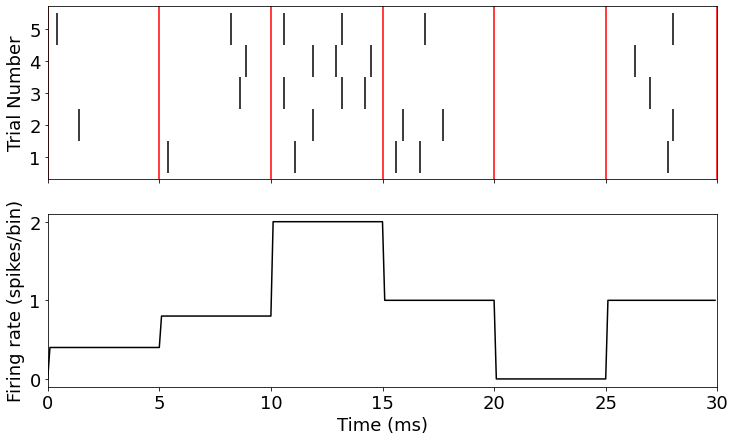

In [ ]:
# @markdown 
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

all_sp_time_list = [np.array([5.4, 11.1, 15.6, 16.7, 27.8]),
                    np.array([1.4, 11.9, 15.9, 17.7, 28]),
                    np.array([8.6, 10.6, 13.2, 14.2, 27]),
                    np.array([8.9, 11.9, 12.9, 14.5, 26.3]),
                    np.array([.4, 8.2, 10.6, 13.2, 16.9, 28])]

# Make raster plot
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Make raster of this data
axes[0].eventplot(all_sp_time_list, colors = 'black')

# Label x and y axes (with units!)
axes[0].set( #xlabel = 'Time (ms)', 
       ylabel = 'Trial Number',
       xlim = [0, 30],
       ylim = [-.7, 4.7],
       yticks = [0, 1, 2, 3, 4],
       yticklabels = [1, 2, 3, 4, 5]);

# Plot bin vertical lines 
bin_width = 5
bin_edge_times = np.arange(0, 30.1, bin_width)
for bin_time in bin_edge_times:
  axes[0].plot([bin_time, bin_time], [-.7, 4.7], 'r')

# Make PSTH

binned_spikes, _ = np.histogram(np.concatenate(all_sp_time_list, axis=0), bins = bin_edge_times)

x_vals = np.arange(0, 30, .1)
y_vals = np.zeros((len(x_vals)))
for i_bin in range(len(bin_edge_times) - 1):
  y_vals[(x_vals > bin_edge_times[i_bin]) & (x_vals <= bin_edge_times[i_bin + 1])] = binned_spikes[i_bin] / 5

axes[1].plot(x_vals, y_vals,  'k');

axes[1].set(xlabel = 'Time (ms)', 
            ylabel = 'Firing rate (spikes/bin)');
            

Remember from the last lecture that our Poisson distribution is:

$$p(y_{t, k} | \lambda_t) = \frac{\lambda_t^{y_{t, k}} e^{-\lambda_{t}}}{y_{t,k}!} $$

where 

$y_{t, k}$: spike count for bin $t$ and trial $k$

$\lambda_t$: firing rate in terms of spikes per bin

$p(y_{t, k} | \lambda_t)$: the probability of the spike count being equal to some number given the firing rate


Let's just look at a single time bin $t$. We want to find the $\lambda_t$ that maximizes the probability of seeing the spike counds $y_{t, k}$ for k from 1 to the number of trials, $n$. The likelihood of seeing those spike counts given $\lambda_t$ is $L(\lambda_t)$.

$$L(\lambda_t) = p(y_{t,1:n} | \lambda_t) $$

We assume the spike count on each trial is independent so we can turn this into a product of the probabilities of the spike counts on each trial:

$$L(\lambda_t) = \prod_{k=1}^{n}p(y_{t, k} | \lambda_t) $$

We actually want the log of the likelihood (for reasons I won't go into here). The log of a times b equals the log of a plus the log of b, so we can turn the product into a sum of logs.

$$log(L(\lambda_t)) = \sum_{k=1}^{n}log(p(y_{t, k} | \lambda_t)) $$

Let's substitute in what $p(y_{t,k}|\lambda_t)$ equals and do some simplifying:

\begin{align}
log(L(\lambda_t)) &= \sum_{k=1}^{n}log(p(y_{t, k} | \lambda_t))\\
&= \sum_{k=1}^{n}log(\frac{\lambda_t^{y_{t, k}} e^{-\lambda_{t}}}{y_{t,k}!}) \\
&= \sum_{k=1}^{n} [log(\lambda_t^{y_{t,k}}) + log(e^{-\lambda_t}) - log(y_{t,k}!)]\\
&= \sum_{k=1}^{n} [y_{t,k}log(\lambda_t) -\lambda_t - log(y_{t,k}!)]\\
\end{align}

We want to find the $\lambda_t$ that maximizes this. The maximums and minimums of functions occur when the derivative is zero. We can compute the derivative of the log likelihood function with respect to $\lambda_t$, set it equal to 0, and solve for $\lambda_t$.

\begin{align} 
\frac{d log(L(\lambda_t))}{d \lambda_t} = \sum_{k=1}^n [ \frac{y_{k, t}}{\lambda_t} - 1] &= 0 \\
\sum_{k=1}^n [ \frac{y_{k, t}}{\lambda_t}] - n &= 0 \\
\sum_{k=1}^n [ \frac{y_{k, t}}{\lambda_t}] &= n\\ 
 \frac{\sum_{k=1}^n y_{k, t}}{\lambda_t} &= n\\
 \sum_{k=1}^n y_{k, t} &= n\lambda_t \\
 \lambda_t &= \frac{\sum_{k=1}^n y_{k, t}}{n}
\end{align}


The value of $\lambda_t$ that maximizes the probability of seeing the spike counts under a Poisson distribution is the mean of those spike counts across trials, exactly what we were using to compute our PSTH! 

## Section 1.2: Finding the linear filter for data

The process of finding the linear filter based on the data from a neuron is a similar idea. We want to maximize the log likelihood of the spikes given $\lambda$. Instead of looking over trials, we will now look over time bins, we want to maximize the probability of the spike counts in multiple time bins given the $\lambda_t$ in each time bin.

\begin{align}
log(L(\lambda)) &= \sum_{t=1}^{T} [y_{t}log(\lambda_t) -\lambda_t - log(y_{t}!)]\\
\end{align}

Now however, $\lambda_t$ depends on our linear filter $k$ and the stimulus.

\begin{align}
\lambda_t &= e^{x_t \cdot k}\\
log(L(\lambda)) &= \sum_{t=1}^{T} [y_{t}log(\lambda_t) -\lambda_t - log(y_{t}!))]\\
\end{align}

We can not set the derivative of this equal to 0 and solve for $k$, it is impossible to distangle $k$ from the dot product with $x_t$.  Instead we have to use other methods to find the $k$ that maximizes this quantity. Most of these methods find parameters that minimize a function, not maximize, which we can easily adhere to by finding the filter $k$ that minimizes the negative log likelihood (NLL):

\begin{align}
NLL &= -\sum_{t=1}^{T} [y_{t}log(\lambda_t) -\lambda_t - log(y_{t}!)]\\
\end{align}

We can get rid of the last term - we want to find the linear filter $k$ that minimizes the negative log likelihood and the last term is not affected by the linear filter - it will be a constant.

\begin{align}
NLL &= -\sum_{t=1}^{T} [y_{t}log(\lambda_t) -\lambda_t ]\\
\end{align}

We can vectorize this computation for ease of coding: if $\lambda$ is a vector of our predicted firing rates over time and $y$ is a vector of our spike counts over time, we can rewrite the above as:

\begin{align}
NLL &= - y \cdot log(\lambda) + \sum_{t=1}^T\lambda_t\\
\end{align}

Now that we have it simplified, how do we actually find the linear filter that minimizes this NLL? Luckily, we have a python function that finds the parameters that minimize a metric for us: `scipy.optimize.minimize`. If you pass a function that computes the negative log likelihood given an input of a linear filter, it will find the minimizing linear filter. 

## Section 1.3: White noise stimuli

If your stimuli is a white noise stimuli, the STA is a pretty good estimate for $k$. You can then find the nonlinearity as described in "Characterizing the Nonlinearity" in https://jov.arvojournals.org/article.aspx?articleid=2192881?

# Section 2: Benefits/drawbacks of LNPs



## Section 2.1: Benefits

- Linear-nonlinear-Poisson models are a fairly simple encoding model and are fairly interpretable in terms of how they are capturing neural processing. The linear filter is similar to a receptive field. 

- These models are easy to fit. If we choose an exponential nonlinearity (or certain other ones), the negative log likelihood will be convex. This means that it is easier to learn the parameters, as we will learn about next lecture. 

- These models also have worked pretty well. We can get good predictions of neural responses for neurons in early sensory and motor areas. 

- These models are easy to add extensions to. People have altered these models to incorporate the spiking history of the neuron (and thus capture things like refractory period or spike frequency adaptation) or the responses of neighboring neurons. We can add more filters from the stimulus that interact in complex ways. 

## Section 2.2: Drawbacks

- This model makes a lot of assumptions about the neural processing, including that the underlying firing rate on each trial is the same. Extensions mentioned in the previous section can alter this and incorporate spiking history.

- The model is quite simple and often doesn't capture more complex neural responses well.

- The linear filters are a bit dangerous to overly interpret. The exact look can depend on various model fitting choices. Instead, it is more safe to use model comparison analysis to make conclusions from LNPs, as detailed in the next section.



# Section 3: Model comparison analysis

How do we make conclusions from linear-nonlinear-Poisson models? One way is to do **model comparison analysis**: we fit models with different inputs or structures and compare which best predict the neuron. 

Let's say we're trying to figure out if a neuron is responding to an auditory stimulus or a visual stimulus. We can fit an LNP model with the auditory stimulus as input, a model with the visual stimulus as input, and one with both auditory and visual stimulus as input. We then evalute the model performance on **held-out data**, or data we have not used to learn the best linear filter. We will see next lecture why this is important.

If the model using the visual stimulus predicts neural responses much better than the auditory stimulus, we can infer that the neuron is primarily responding to the visual stimulus, at least within the context of this specific model. 

In class, we talked about the model comparison analysis approach done in this paper: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41593-019-0502-4. In this paper, they fit encoding models with various inputs related to the task the mouse was performing and movements of the mouse (moving its whiskers, legs, etc). They found that movements of the animal were important for predicting neural responses across the brain, even outside of motor cortices!

We can also change the structure of the model. Researchers added the trial-specific spiking responses of neighboring neurons to help predict the spiking responses of a neuron in this study: https://www.nature.com/articles/nature07140 . This improved prediction, so they concluded that the neurons were correlated beyond their dependence on the stimulus.


# Summary

LNPs are easily fit to data by finding the linear filter that minimizes the negative log likelihood of the spikes given the predicted firing rate. They are a simple descriptive encoding model that can be used to generate insights into what the neurons are responding to, and how.

# Optional Reading

Content:

Notes on Generalized Linear Models (LNPs): https://arxiv.org/pdf/1404.1999.pdf (Links to an external site.)

More in-depth look at fitting models: https://youtube.com/watch?v=m1w7oywzwpA (Links to an external site.)

Could also look at tutorials 1 and 2 for more practice: https://compneuro.neuromatch.io/tutorials/W1D4_GeneralizedLinearModels/student/W1D4_Tutorial1.html# (Links to an external site.)

Video diving further into these types of models:  https://youtube.com/watch?v=NXVG9ORBYXQ (Links to an external site.)

 

Related research papers:

Well-known paper in Nature 2008 using LNPs with spike history: https://www.nature.com/articles/nature07140 (Links to an external site.)

Paper using linear encoding models & model comparison analysis: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41593-019-0502-4Links to an external site.